# Homework 6

The focus of this homework will be Network and Graphs as well as Neural Networks.

## Exercise 1 [25pts]

In this exercise, you will try to recommend new collaborations to researchers
of the Machine Learning community. Our approach will follow the guidelines of
collaborative filtering: “If your past behavior/preferences were similar
to some other user’s, your future behavior may be as well”. As an
example, imagine you like Rolling Stones, Beatles and Jimmy Hendrix. It turns
out that most people that like the aforementioned artists, are also fans of Eric
Clapton. Then, it is very likely that if you listen to Eric Clapton’s music, you
will like it as well.

In this assignment you will implement a recommendation system for suggesting new collaborations to Machine Learning researchers.

A network as a graph: A graph or network represents relationships among
different entities (users of a social network, researchers, products, etc.). Those
entities are represented as nodes and the relationships between them (friends
on Facebook, co-authors of a research paper, products purchased together) as
edges. When there is an edge between two nodes, x and y, we say that y is a
neighbor (or friend) of x (and also - as the graphs we consider are undirected -
x is also a neighbor of y).

Each line of `edges.txt` contains the names of two researchers that have co-authored a paper in one of the top Machine Learning conferences (NeurIPS, ICLR, ICML) between 2010 and 2016.

a) Write a function that reads the file “old edges.txt” and create a
graph using NetworkX. (This is a tab-separated value (TSV) file, you may
use packages such as Pandas to read it.) [5pts]

In [1]:
import networkx as nx
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pygraphviz as pgv

In [2]:
file = pd.read_csv('edges.txt', names=['source', 'target'], sep='\t')
file.head()

,source,target
0,A. David Edwards,Daniel Rueckert
1,A. P. Sarath Chandar,Amrita Saha
2,A. P. Sarath Chandar,Balaraman Ravindran
3,A. P. Sarath Chandar,Hugo Larochelle
4,A. P. Sarath Chandar,Mitesh M. Khapra


In [3]:
graph = nx.from_pandas_edgelist(file, source='source', target='target')
person = 'A. David Edwards'
print('Neighbours:', list(graph[person]))

Neighbours: ['Daniel Rueckert', 'Bertrand Thirion', 'David J. Sharp', 'Emma C. Robinson', 'Fani Deligianni', 'Gaël Varoquaux']


b) Recommend by number of common friends. [10pts]

The intuition behind this recommendation algorithm is that if non-friend
Y is your friend’s friend, then maybe Y should be your friend too. If
person Y is the friend of many of your friends, then Y is an even better
recommendation.

Write a function `common_friends_number(G, X)` that, given G and an author
X, returns a list of recommendations for X. The authors in this list are sorted
by the number of common neighbors they have with X (and are not of course
already friends with X). If there are ties, you can break them arbitrarily.

In [4]:
def common_friends_number(G, X):
    friends = G[X]
    recommendations = Counter()

    for friend in friends:
        for recommendation in G[friend]:
            if recommendation not in friends and recommendation != X:
                recommendations[recommendation] += 1
    
    return sorted(recommendations, key=recommendations.get, reverse=True)

In [5]:
friendRecommendations = common_friends_number(graph, person)
print(friendRecommendations)
print('\nNumber of recommendations', len(friendRecommendations))

['Alexandre Gramfort', 'Arthur Mensch', 'Danilo Bzdok', 'Elvis Dohmatob', 'Evelyn Eger', 'Jean-Baptiste Poline', 'Julien Mairal', 'Michael Eickenberg', 'Olivier Grisel', 'Vincent Michel', 'Yannick Schwartz', 'Amir Alansary', 'Ben Glocker', 'Bernhard Kainz', 'Christina Malamateniou', 'Joseph V. Hajnal', 'Kevin Keraudren', 'Mary A. Rutherford', 'Matthew C. H. Lee', 'Eugene Belilovsky', 'Matthew B. Blaschko']

Number of recommendations 21


c) Make recommendations using Jaccard’s Index. [10points]

If `Γ(X)` is the set of neighbors of X, then the metric we used in part (c), assigns to a non-friend y, the following recommendation score (with respect to X):

$$ \text{score(y)} = |\Gamma(X) \cap \Gamma(y)| $$

Jaccard’s Index scales this score by taking into account the union of X and Y ’s neighbors. Intuitively, X and Y are more similar, if what they have in common is as close as possible to what they have together.

Write a function `jaccard index(G, X)` that given G and an author X, returns a
list of recommendations for X. The authors in this list are sorted by the number
of their Jaccard Index with respect to X (and are not of course already friends
with X). If there are ties, you can break them arbitrarily.

$$ \text{Jaccard Index} = \frac{|\Gamma(X) \cap \Gamma(y)|}{|\Gamma(X) \cup \Gamma(y)|}  $$

In [6]:
def jaccard_index(G, X):
    friends = G[X]
    recommendations = Counter()

    for friend in friends:
        for recommendation in G[friend]:
            if recommendation not in friends and recommendation != X:
                recommendations[recommendation] += 1

    for rec in recommendations:
        recommendations[rec] /= len(set(G[X]) | set(G[rec]))
    
    return sorted(recommendations, key=recommendations.get, reverse=True)

In [7]:
friendRecommendations = jaccard_index(graph, person)
print(friendRecommendations)
print('\nNumber of recommendations', len(friendRecommendations))

['Yannick Schwartz', 'Elvis Dohmatob', 'Jean-Baptiste Poline', 'Arthur Mensch', 'Danilo Bzdok', 'Evelyn Eger', 'Michael Eickenberg', 'Olivier Grisel', 'Vincent Michel', 'Alexandre Gramfort', 'Eugene Belilovsky', 'Julien Mairal', 'Amir Alansary', 'Ben Glocker', 'Bernhard Kainz', 'Christina Malamateniou', 'Joseph V. Hajnal', 'Kevin Keraudren', 'Mary A. Rutherford', 'Matthew C. H. Lee', 'Matthew B. Blaschko']

Number of recommendations 21


## Exercise 2 [55pts]

This exercise will focus on Neural Networks and visualization.

a) Write a function that takes a keras network and outputs an image (png format) of the network. [10pts]

You can assume the model is sequential and only uses dense layers. The output image for

```python
    model = keras.models.Sequential()
    model.add(layers.Dense(2, input_dim=2))
    model.add(layers.Dense(1))
    model.compile(loss="binary_crossentropy")
```

should look something like this

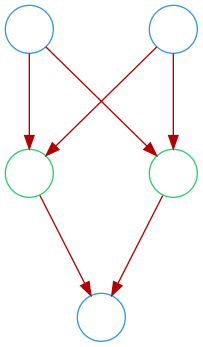

In [8]:
from IPython.display import Image
Image(filename="example.png")

Hint: use the networkx library (specifically the [to_agraph](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_agraph.to_agraph.html) method)

In [9]:
def visualiseNetwork(network, filename = 'graph'):
    G = nx.DiGraph(nodesep='1', ranksep='1')

    # Iterate over the layers
    for layer_index, layer in enumerate(network.layers):

        for i in range(layer.input_shape[1]):
            colour = ''
            if layer_index == 0:    # Input Node
                colour = "#0000FF"
            else:   # Hidden Node
                colour = "#00FF00"


            G.add_node(str(layer_index) + ',' + str(i),
                               shape="circle",
                            #    color="#00FF00",
                               color=colour,
                               label='')


            for j in range(layer.output_shape[1]):
                if layer_index == len(network.layers) - 1:  # Output Node
                    G.add_node(
                        str(layer_index + 1) + ',' + str(j),
                        shape="circle",
                        color="#0000FF",
                        label=''
                    )
                
                # Connect the nodes between the layers
                G.add_edge(
                    str(layer_index) + ',' + str(i),
                    str(layer_index + 1) + ',' + str(j),
                    color="#FF0000"
                )

    
    img = nx.nx_agraph.to_agraph(G)
    img.layout(prog='dot')
    img.draw(filename + '.png')
    


2022-04-28 20:04:46.630865: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


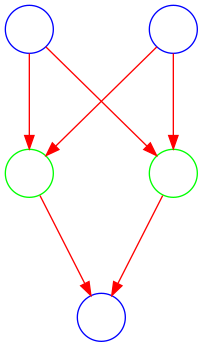

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import random
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from PIL import Image as im

model = keras.models.Sequential()
model.add(layers.Dense(2, input_dim=2))
model.add(layers.Dense(1))
model.compile(loss="binary_crossentropy")

visualiseNetwork(model, '2a')
Image(filename='2a.png')

b) Generate 100 datapoints of the form y = 3x + 1 + e where e ~ N(0, 1) and plot the data in a scatter plot [5pts]

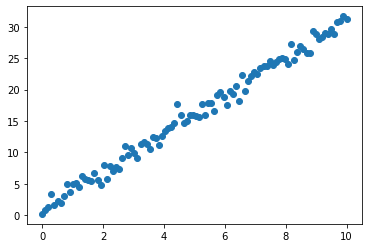

In [11]:
X = np.linspace(0, 10, 100)
Y = np.array([3 * x + 1 + random.normalvariate(0, 1) for x in X])

plt.scatter(X, Y)

c) Create a Neural Network with no hidden layers (just input to ouput each with just one neuron), using the `mean_squared_error` loss and no activation function. Create an image of this model using a) then train this model on the dataset from b). In a 3D plot, plot the weight, the bias, and the loss value. [10pts]

/var/folders/ng/j5r0140j13j3wttzxw4f3sdc0000gn/T/ipykernel_9201/266860317.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


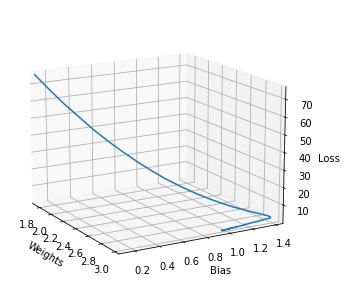

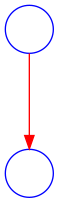

In [14]:
model = keras.models.Sequential()
model.add(layers.Dense(units=1, input_dim=1))
model.compile(loss='mean_squared_error')


weights, bias = [], []
get_weights = LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights.append(model.get_weights()[:-1]))
get_bias = LambdaCallback(
    on_epoch_end=lambda epoch, logs: bias.append(model.get_weights()[1]))

history = model.fit(X,
                Y,
                batch_size=1,
                epochs=200,
                callbacks=[get_weights, get_bias],
                verbose=0)

loss = history.history['loss']
weights = np.asarray(weights)[:, 0, 0, 0].tolist()
bias = np.asarray(bias)[:, 0].tolist()

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(weights, bias, loss)

ax.set_xlim3d([min(weights), max(weights)])
ax.set_xlabel('Weights')

ax.set_ylim3d([min(bias), max(bias)])
ax.set_ylabel('Bias')

ax.set_zlim3d([min(loss), max(loss)])
ax.set_zlabel('Loss')

ax.view_init(15, -30)
plt.show()
visualiseNetwork(model, filename='2c')
Image('2c.png')

d) Using matplotlib animation, re-train the model from c) and create an animation of the weight, bias, and loss at each training epoch. [10pts]

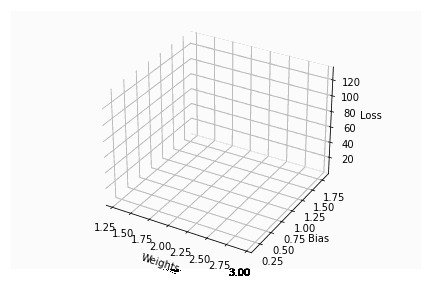

In [15]:
weights, bias = [], []

model = keras.models.Sequential()
model.add(layers.Dense(units=1, input_dim=1))
model.compile(loss='mean_squared_error')

weights, bias = [], []
history = model.fit(X,
                    Y,
                    batch_size=1,
                    epochs=200,
                    callbacks=[get_weights, get_bias],
                    verbose=0)

loss = history.history['loss']
weights = np.asarray(weights)[:, 0, 0, 0].tolist()
bias = np.asarray(bias)[:, 0].tolist()

fig = plt.figure()
fig.set_tight_layout(True)
ax = fig.add_subplot(projection='3d')


def update(num):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    return line


data = np.asarray([weights, bias, loss])
line, = ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1])

ax.set_xlim3d([min(weights), max(weights)])
ax.set_xlabel('Weights')

ax.set_ylim3d([min(bias), max(bias)])
ax.set_ylabel('Bias')

ax.set_zlim3d([min(loss), max(loss)])
ax.set_zlabel('Loss')

ani = animation.FuncAnimation(fig, update, interval=20, blit=False)

ani.save('2d.gif', writer='pillow')
plt.close()
Image('2d.gif')

e) Generate data of the form y = 3x^3 + 2x^2 + x + 1 + e where e ~ N(0, 1) and plot the data in a scatter plot [5pts]

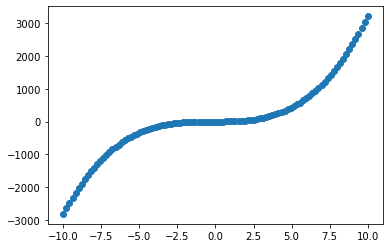

In [16]:
X = np.linspace(-10, 10, 100)
Y = np.array([
    3 * (x**3) + 2 * (x**2) + x + 1 + random.normalvariate(0, 1) for x in X
])

plt.scatter(X, Y)

f) Create and train a neural network on the dataset from e) and plot the resulting curve through the scatter plot. (you can use any number of epochs, hidden layers etc.) Also create an image of the network using the function from a) [10pts]

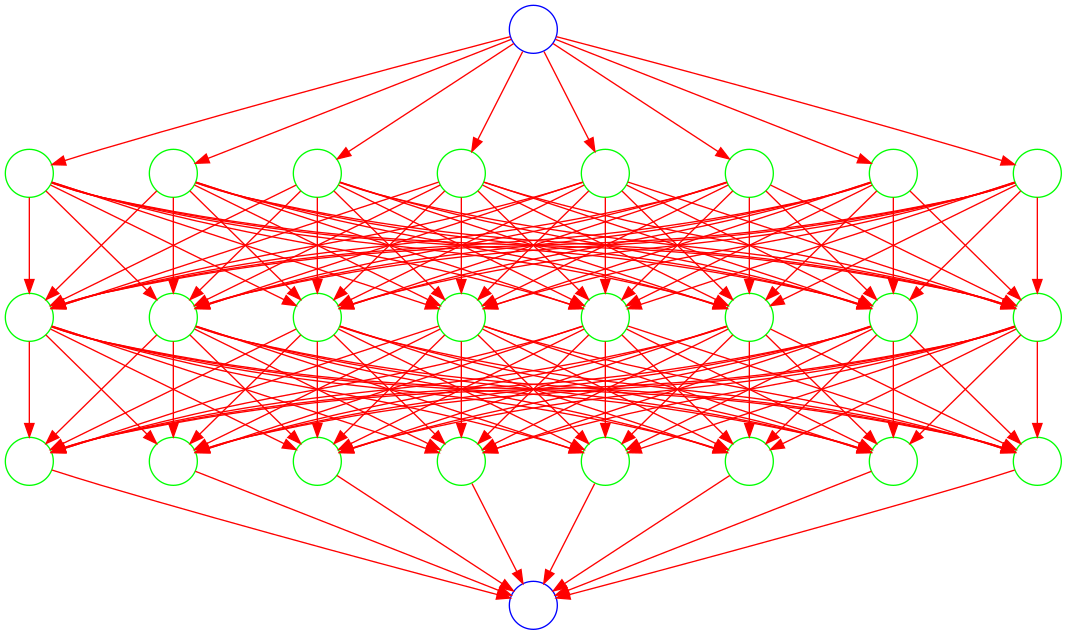

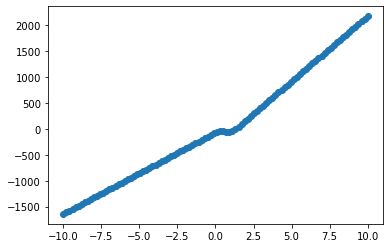

In [17]:
model = keras.models.Sequential()
model.add(layers.Dense(units=8, activation='relu', input_dim=1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

visualiseNetwork(model, '2f')

model.fit(X, Y, epochs=400, verbose=0, batch_size=10)

plt.scatter(X, model.predict(X))
Image('2f.png')

g) Using matplotlib animation, create an animation of the resulting curve from your model at each training epoch (up to 100 epochs). [5pts]

In [18]:
def helper(x, model, filename):
    fig, ax = plt.subplots()
    ax.scatter(x, model.predict(x))
    fig.savefig(filename + '.png')
    plt.close()
    return np.asarray(im.open(filename + '.png'))

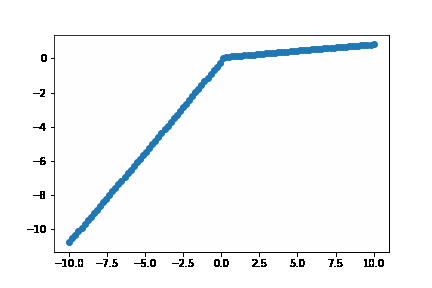

In [21]:
images = []
epochs = 500
filename = '2g'

model = keras.models.Sequential()
model.add(layers.Dense(units=8, activation='relu', input_dim=1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

for _ in range(int(epochs / 10)):
    model.fit(X, Y, epochs=10, verbose=0, batch_size=10)
    images.append(im.fromarray(helper(X, model, filename)))

images[0].save(
    filename + '.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=300
)

Image(filename + '.gif')

## Exercise 3 [20pts]

This exercise will focus on Neural Networks.



In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms 
from torch.optim import SGD, Adam
from tqdm import tqdm 

a) Modify the number of layers to include atleast 2 hidden layers with appropriate number of neurons that use the sigmoid function in the forward pass: [5pts]

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size):
    super(NeuralNetwork, self).__init__()
    # You are free to define any number of layers you want to here

    self.layer1 = nn.Linear(input_size, 800)
    # your code here
    self.layer2 = nn.Linear(800, 800)
    self.layer3 = nn.Linear(800, 300)

    self.output = nn.Linear(300, 10)  
    self.dropout = nn.Dropout(0.2)


  def forward(self, input):
    x = F.relu(self.layer1(input))
    
    # your code here
    # x = self.sigmoid(self.layer2(x))
    # x = self.sigmoid(self.layer3(x))
    x = torch.sigmoid(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))

    x = self.dropout(x)
    outputs = self.output(x)

    # ??
    # return F.softmax(outputs)
    return F.softmax(outputs, dim=-1)

b) Modify the following values to provide the highest accuracy on your Neural Network [2pts]

In [ ]:
epochs = 10                      # number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # device
criterion = nn.CrossEntropyLoss() # loss function
batch_size = 500

Run the following cell everytime you update parts a and b

In [ ]:
net = NeuralNetwork(784).to(device)
optimizer = Adam(net.parameters(), lr = 1e-2)

total_loss = 0


#######################################
### Downloading the data


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last=True)
train_dataloader2 = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last=True)
test_dataloader2 = torch.utils.data.DataLoader(test_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=2,
                                               drop_last=True)


c) You may change the model to increase the accuracy of this model. The goal is to attain the highest possible accuracy. You do not get marks for accuracies less than 83%. You may modify the values in parts a and b [8pts]

In [ ]:
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs.view(batch_size,-1).to(device))

        labels_ = F.one_hot(labels, num_classes= 10)

        loss = criterion(outputs,labels_.to(device).float())
        loss.backward()  # update network parameters

        optimizer.step() # update the optimizer parameters

        total_loss += loss.item()
        epoch_loss += loss.item()

    with torch.no_grad():
        net.eval()
        correct = 0
        total = 0
        for i, data in enumerate(train_dataloader2):
            input, labels = data
            outputs = net(input.view(batch_size,-1).to(device))

            total+= len(labels)

            predictions = torch.argmax(outputs, dim = 1)
            predictions = predictions.to("cpu").numpy()
            correct += sum(1*(labels.numpy()==predictions))

    with torch.no_grad():
        net.eval()
        correct_test = 0
        total_test = 0
        for i, data in enumerate(test_dataloader):
            input, labels = data
            outputs = net(input.view(batch_size,-1).to(device))

            total_test+= len(labels)

            predictions = torch.argmax(outputs, dim = 1)
            predictions = predictions.to("cpu").numpy()
            correct_test += sum(1*(labels.numpy()==predictions))

    print(
        " — epoch loss = %1.2f — training accuracy = %1.2f — test accuracy = %1.2f"
        % (epoch_loss, correct / total, correct_test / total_test))


d) Explain in ~150 words the method you used to increase the accuracy. [5pts]